In [4]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_sparse_spd_matrix
from corner import corner

from active_learning_ratio_estimation.dataset import RatioDataset
from active_learning_ratio_estimation.util import ideal_classifier_probs, negative_log_likelihood_ratio
from active_learning_ratio_estimation.model import RegularRatioModel, BayesianRatioModel

%matplotlib inline

np.random.seed(0)
tf.random.set_seed(0)

In [5]:
class MultiDimDist:
    DIM = 5

    def __init__(self, alpha, beta, R=None):
        self.alpha = alpha
        self.beta = beta
        if R is not None:
            assert R.shape == (self.DIM, self.DIM)
            self.R = R
        else:
            self.R = make_sparse_spd_matrix(self.DIM, alpha=0.5, random_state=7)
        self.dists = self.build_distributions(alpha, beta)

    @staticmethod
    def build_distributions(alpha, beta):
        dists = [
            tfd.Normal(loc=alpha, scale=1),
            tfd.Normal(loc=beta, scale=3),
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
                components_distribution=tfd.Normal(
                    loc=[-2, 2],
                    scale=[1, 0.5]
                )
            ),
            tfd.Exponential(3),
            tfd.Exponential(0.5)
        ]
        return dists

    def sample(self, n):
        raw_samples = np.stack([dist.sample(n) for dist in self.dists], axis=1)
        samples = np.einsum('ij, kj -> ki', self.R, raw_samples)
        assert np.allclose(samples[0, :], np.matmul(self.R, raw_samples[0, :]))
        return samples

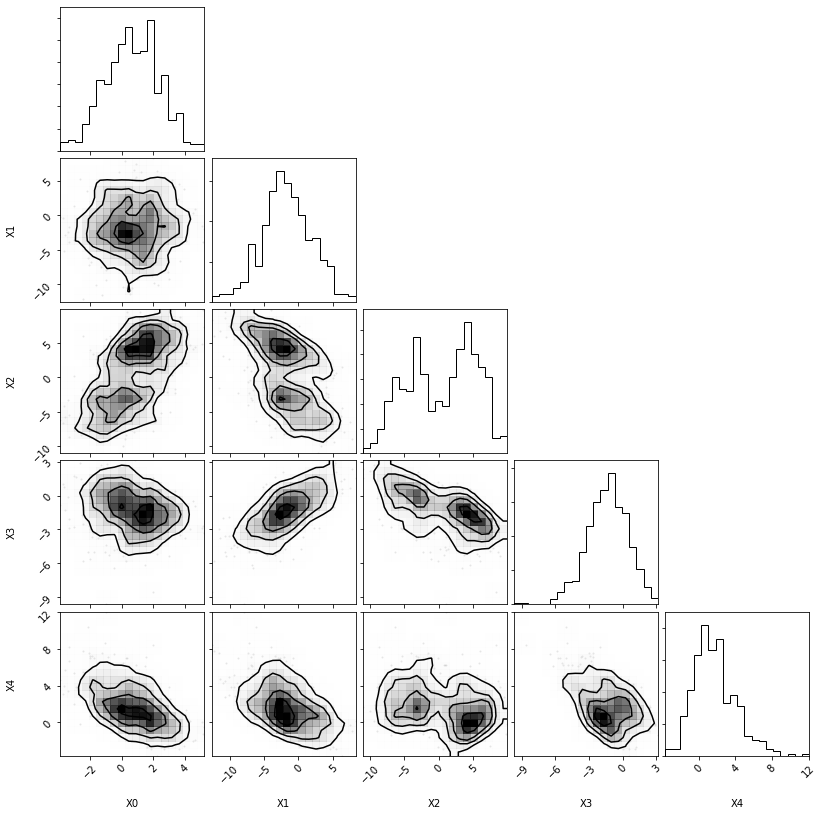

In [8]:
# Plot histograms / correlations of true distributions
true_alpha = 1
true_beta = -1
true_dist = MultiDimDist(alpha=1, beta=-1)
X_true = true_dist.sample(500)
fig = corner(X_true, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])

In [ ]:
# create dataset
ds = 